<a href="https://colab.research.google.com/github/Newton001/Food_Classification/blob/main/Classification_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import logging
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras import backend as K

#Set up some google colab stuff
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
data_folder_path = '/content/drive/MyDrive'

root_dir = os.getcwd()
print(data_folder_path)

/content/drive/MyDrive


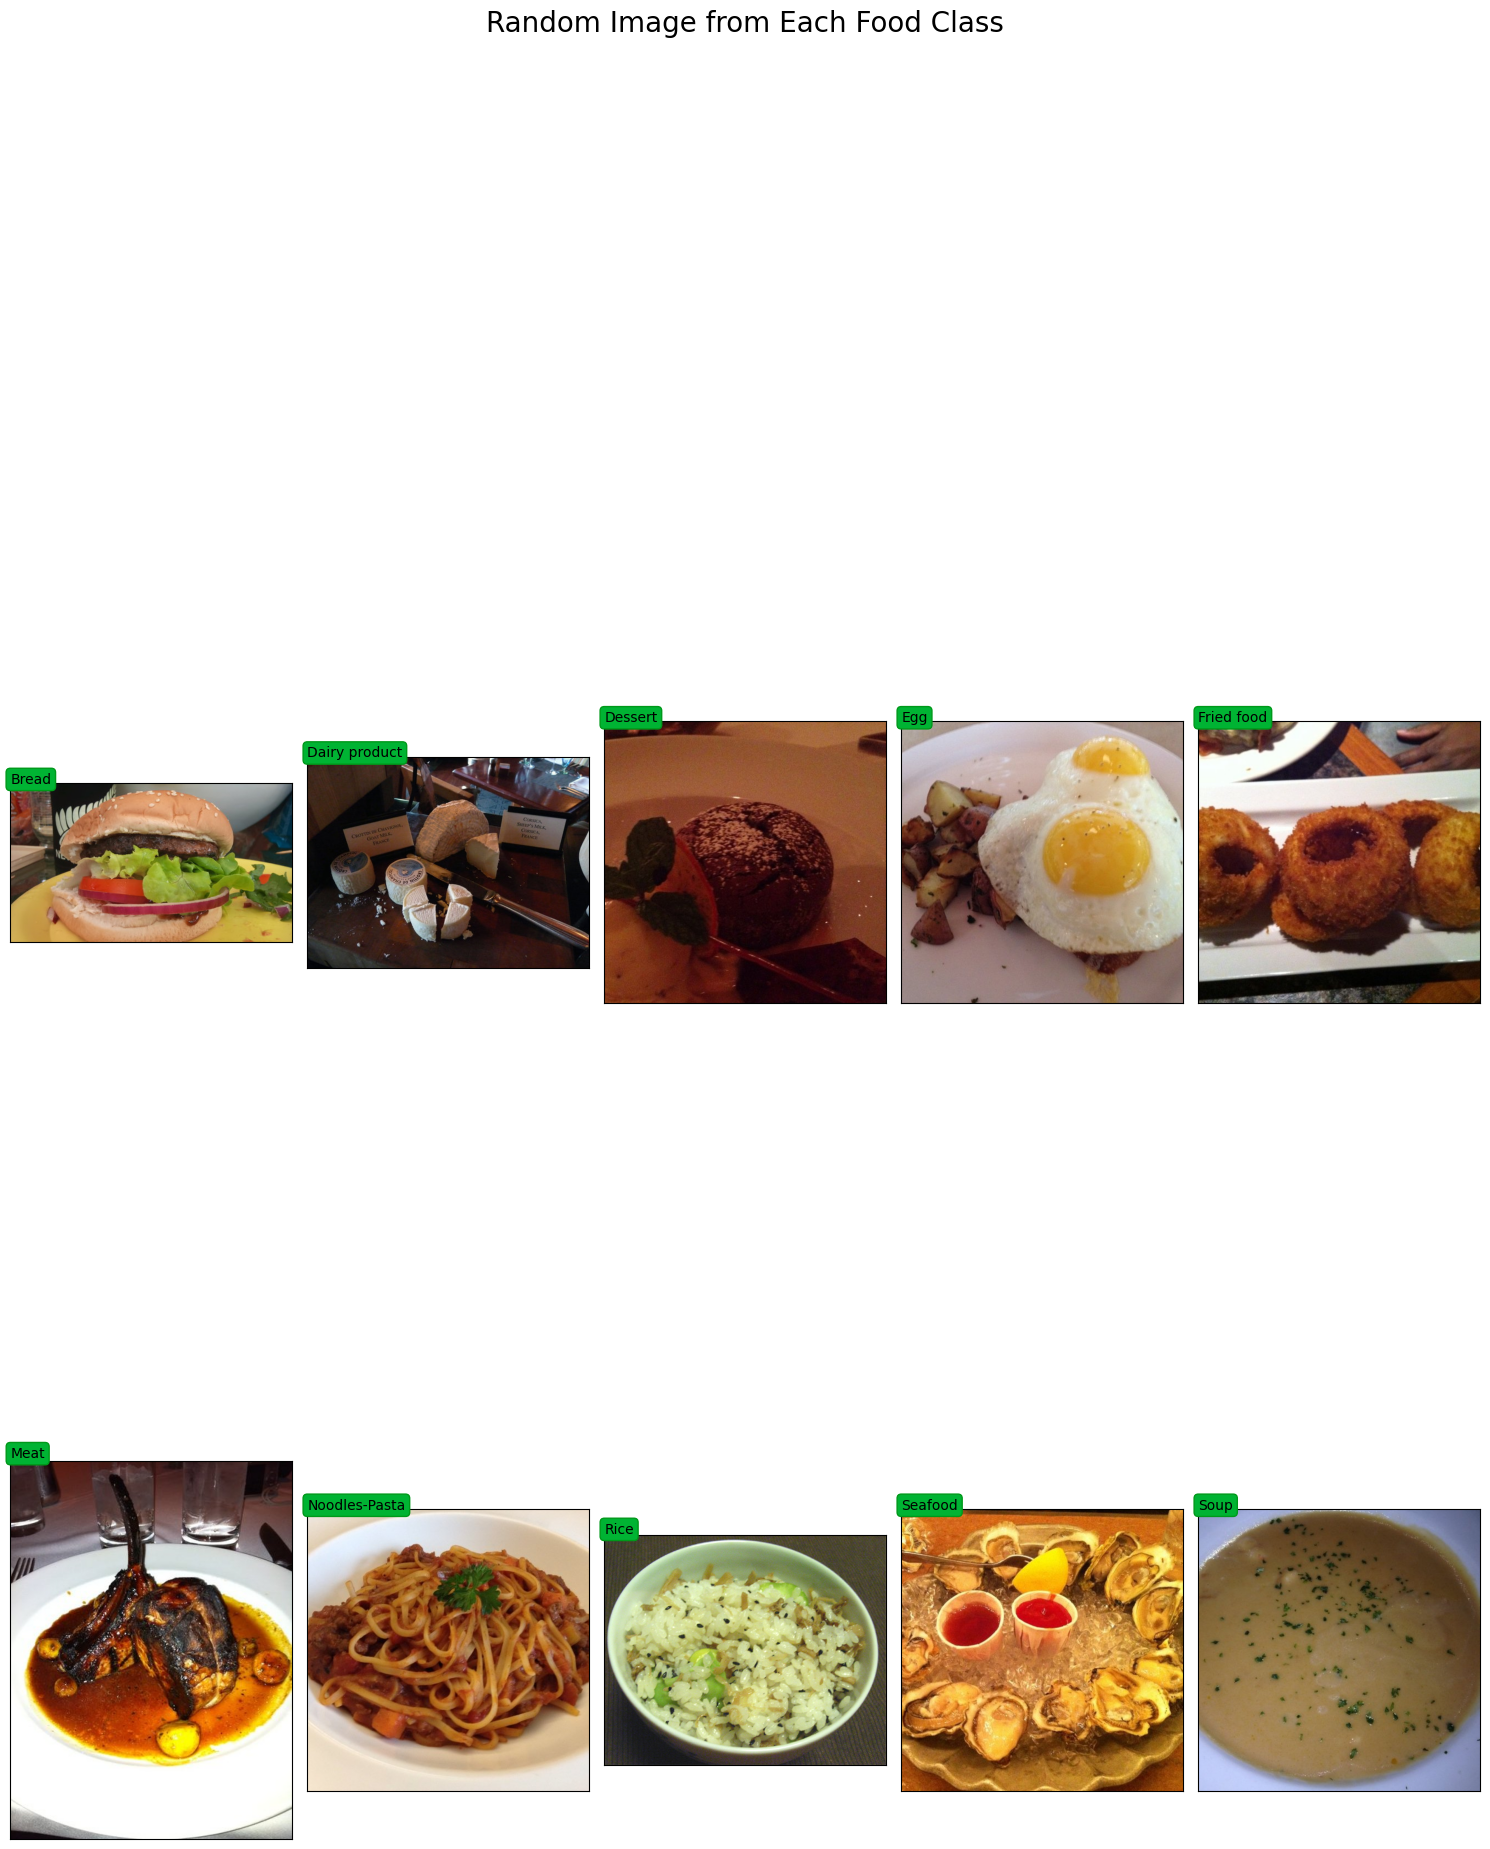

In [4]:
root_dir = data_folder_path + "/Food11/training/"
rows = 2
cols = 5
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle("Random Image from Each Food Class", fontsize=20)

sorted_food_dirs = sorted(os.listdir(root_dir))

for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i * cols + j]
        except:
            break
        full_path = os.path.join(root_dir, food_dir)
        if os.path.isdir(full_path):
            all_files = os.listdir(full_path)
            rand_img = np.random.choice(all_files)
            img = plt.imread(os.path.join(full_path, rand_img))
            ax[i, j].imshow(img)
            ec = [0, .6, .1]
            fc = (0, 0.7, .2)
            ax[i, j].text(0, -20, food_dir, size=10, rotation=0,
                          ha="left", va="top",
                          bbox=dict(boxstyle="round", ec=ec, fc=fc))
        else:
            print(f"Not a directory: {full_path}")

plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [5]:
#Path Folder
current_path = os.getcwd()
log_file_path = current_path+'\logfile.txt'
logging.basicConfig(filename=log_file_path, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

logging.info('Code Start.')

data_dir_training = data_folder_path +"/Food11/training/"
data_dir_training = pathlib.Path(data_dir_training).with_suffix('')

data_dir_validation = data_folder_path +"/Food11/validation/"
data_dir_validation = pathlib.Path(data_dir_validation).with_suffix('')

data_dir_evaluation = data_folder_path +"/Food11/evaluation/"
data_dir_evaluation = pathlib.Path(data_dir_evaluation).with_suffix('')

model_path = data_folder_path +"/model"
history_path = data_folder_path +'/model/trainingHistory.json'

Data Preprocess

In [6]:
class_names = np.array(sorted([item.name for item in data_dir_training.glob('*')]))
num_of_classes = len(class_names)
print(class_names, num_of_classes)

['Bread' 'Dairy product' 'Dessert' 'Egg' 'Fried food' 'Meat'
 'Noodles-Pasta' 'Rice' 'Seafood' 'Soup' 'Vegetable-Fruit'] 11


In [7]:
tf.random.set_seed(42)
generator = ImageDataGenerator(rescale = 1./255.,
                              validation_split=0.2,
                              horizontal_flip=True,
                              vertical_flip=False,
                              zoom_range=0.05,
                              rotation_range=25)

In [8]:
train_data = generator.flow_from_directory(data_dir_training,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               subset = "training",
                                               class_mode="categorical",
                                               seed=42)

test_data = generator.flow_from_directory(data_dir_validation,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               subset = "validation",
                                               class_mode="categorical",
                                               seed=42)


eval_data = generator.flow_from_directory(data_dir_evaluation,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               subset = "validation",
                                               class_mode="categorical",
                                               seed=42)


Found 7904 images belonging to 11 classes.
Found 683 images belonging to 11 classes.
Found 666 images belonging to 11 classes.


## Call Backs

In [9]:
def create_callbacks():
    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=10,
        verbose=1
    )
    callbacks = [earlystop]
    return callbacks

## Create CNN Model

In [10]:
# Define the convolutional layers
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')
conv5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')

# Define the max pooling layers
max_pool1 = tf.keras.layers.MaxPooling2D((2, 2))
max_pool2 = tf.keras.layers.MaxPooling2D((2, 2))
max_pool3 = tf.keras.layers.MaxPooling2D((2, 2))

# Define the fully connected layers
fc1 = tf.keras.layers.Dense(1024, activation='relu')

# Define the output layer
output = tf.keras.layers.Dense(11, activation='softmax')

# Create the model
model = tf.keras.Sequential([
    conv1,
    max_pool1,
    conv2,
    max_pool2,
    conv3,
    max_pool3,
    conv4,
    conv5,
    tf.keras.layers.Flatten(),
    fc1,
    output
])

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
callbacks = create_callbacks()

In [ ]:
history = model.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),batch_size=32,
                        verbose=1,callbacks=callbacks)



Epoch 1/20
247/247 [==============================] - 2874s 12s/step - loss: 2.2670 - accuracy: 0.1942 - val_loss: 2.2036 - val_accuracy: 0.2064
Epoch 2/20
247/247 [==============================] - 1558s 6s/step - loss: 2.0347 - accuracy: 0.2775 - val_loss: 1.9115 - val_accuracy: 0.3104
Epoch 3/20
247/247 [==============================] - 1553s 6s/step - loss: 1.8482 - accuracy: 0.3451 - val_loss: 1.7906 - val_accuracy: 0.3411
Epoch 4/20
247/247 [==============================] - 1557s 6s/step - loss: 1.7678 - accuracy: 0.3832 - val_loss: 1.7779 - val_accuracy: 0.3616
Epoch 5/20
 11/247 [>.............................] - ETA: 24:51 - loss: 1.6556 - accuracy: 0.4233

In [ ]:

model.evaluate(eval_data)

In [ ]:
model.save(data_folder_path + '/NormNet.h5')

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
y_pred = model.predict(test_data)

In [ ]:
print("y pred before: ",y_pred[:5])
y_pred = y_pred.argmax(axis=1)
print("y pred after: ",y_pred[:5])

# EfficientNet Transfer Learning

In [ ]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
feature_extractor_layer = hub.KerasLayer(efficientnet_url,
                                         trainable=True,
                                         name='feature_extraction_layer',
                                         input_shape=(224, 224, 3))

In [ ]:
model_efficientNet = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_of_classes, activation='softmax', name='output_layer')
])

In [ ]:
model_efficientNet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
efficientnet_model = model_efficientNet.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),batch_size=32,
                        verbose=1,callbacks=callbacks)

In [ ]:
model_efficientNet.evaluate(eval_data)


model_efficientNet.save(data_folder_path + '/efficientNet.h5')

In [ ]:
pd.DataFrame(efficientnet_model.history).plot()
y_pred_tl = model_efficientNet.predict(eval_data)


print("y pred before: ",y_pred_tl[:5])
y_pred_tl = y_pred_tl.argmax(axis=1)
print("y pred after: ",y_pred_tl[:5])

# ResNet Learning Model

In [ ]:
ResNet_v2_50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'

model_ResNet = tf.keras.Sequential([
    hub.KerasLayer(ResNet_v2_50,trainable=True, input_shape=(250,250,3), name='Resnet_v2_50'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(11, activation='softmax', name='Output_layer')
])

model_ResNet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model_ResNet.summary()

### Lets Run it Now

In [ ]:
resnet_model = model_ResNet.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),batch_size=32,
                        verbose=1,callbacks=callbacks)

In [ ]:
model_ResNet.evaluate(eval_data)

model_ResNet.save(data_folder_path + '/ResNet.h5')


In [ ]:
pd.DataFrame(resnet_model.history).plot()
y_pred_tl = model_ResNet.predict(eval_data)


print("y pred before: ",y_pred_tl[:5])
y_pred_tl = y_pred_tl.argmax(axis=1)
print("y pred after: ",y_pred_tl[:5])

## Compare the Three Models

## Inception V3 MODEL

In [ ]:
inceptionv3_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

# Create a Keras layer using the URL
feature_extractor_layer_inc = hub.KerasLayer(
    inceptionv3_url,
    trainable=True,
    name='feature_extraction_layer',
    input_shape=(224, 224, 3)  # Correct input shape
)

# Build a simple model using the feature extractor layer
model_inceptionv3 = tf.keras.Sequential([
    feature_extractor_layer_inc,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(num_of_classes, activation='softmax', name='output_layer')
])

# Compile the model
model_inceptionv3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

inception_model = model_inceptionv3.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),batch_size=32,
                        verbose=1,callbacks=callbacks)

# Display the model summary
model_inceptionv3.summary()

In [ ]:
model_inceptionv3.evaluate(eval_data)

model_inceptionv3.save(data_folder_path + '/inceptionv3.h5')

In [ ]:
pd.DataFrame(resnet_model.history).plot()
y_pred_tl = model_inceptionv3.predict(eval_data)


print("y pred before: ",y_pred_tl[:5])
y_pred_tl = y_pred_tl.argmax(axis=1)
print("y pred after: ",y_pred_tl[:5])

Gradient CAMs

In [ ]:
def get_grad_cam(model, img_path, class_index, layer_name='block5_conv3'):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get the class predictions
    preds = model.predict(img_array)
    class_output = model.output[:, class_index]

    # Get the specified layer output
    last_conv_layer = model.get_layer(layer_name)
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([img_array])

    for i in range(last_conv_layer.output_shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to match the original image
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    heatmap = np.uint8(255 * heatmap)

    # Apply heatmap to the original image
    img = cv2.imread(img_path)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return superimposed_img

## VGG1NET

In [ ]:
# Create a VGG16 base model (excluding the top dense layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = True

# Create a new model on top of the VGG16 base model
model_vgg16 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')  # Change the number of units based on your classification task
])

# Compile the model
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_vgg16.summary()

history_model_vgg16 = model_vgg16.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    batch_size=32,
)

In [ ]:
model_vgg16.save(data_folder_path + '/model_vgg16.h5')
tf.keras.utils.plot_model(model_ResNet)
tf.keras.utils.plot_model(model_efficientNet)
tf.keras.utils.plot_model(model_inceptionv3)
tf.keras.utils.plot_model(model)
tf.keras.utils.plot_model(model_vgg16)


history_model_vgg16 =

In [ ]:
def plot_graph(history, history_1, history_2, history_4, history_3):
    loss_norm = history_2.history['loss']
    loss_res = history.history['loss']
    loss_ef = history_1.history['loss']
    loss_inc = history_4.history['loss']
    loss_vgg = history_3.history['loss']

    min_length = min(len(loss_norm), len(loss_res), len(loss_ef), len(loss_inc))

    accuracy_res = history.history['accuracy'][:min_length]
    accuracy_ef = history_1.history['accuracy'][:min_length]
    accuracy_norm = history_2.history['accuracy'][:min_length]
    accuracy_inc = history_4.history['accuracy'][:min_length]
    accuracy_vgg = history_3.history['accuracy'][:min_length]

    epochs = range(min_length)

    plt.plot(epochs, loss_norm[:min_length], label='NormNet Loss')
    plt.plot(epochs, loss_res[:min_length], label='ResNet Loss')
    plt.plot(epochs, loss_ef[:min_length], label='Efficientnet Loss')
    plt.plot(epochs, loss_inc[:min_length], label='InceptionV3 Loss')
    plt.plot(epochs, loss_vgg[:min_length], label='VGG1 Loss')
    plt.title('Epochs Vs Loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy_norm, label='NormNet Accuracy')
    plt.plot(epochs, accuracy_res, label='ResNet Accuracy')
    plt.plot(epochs, accuracy_ef, label='Efficientnet Accuracy')
    plt.plot(epochs, accuracy_inc, label='Inception_v3 Accuracy')
    plt.plot(epochs, accuracy_vgg, label='VGG1 Accuracy')
    plt.title('Epochs Vs Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()



plot_graph(resnet_model, efficientnet_model, history,inception_model,history_model_vgg16)

### Lets Fit our Model

In [ ]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def get_grad_cam(model, img_path, class_index, layer_name):
    img_array = load_and_preprocess_image(img_path)

    # Create a model that maps the input image to the activations of the specified layer
    grad_model = keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    # Get the gradients of the predicted class with regard to the output feature map
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    # Extract the gradients and compute the guided gradients
    grads = tape.gradient(loss, conv_output)[0]
    guided_grads = tf.cast(conv_output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    # Compute the guided Grad-CAM
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_output[0]), axis=-1)

    # Resize the CAM to match the original image size
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)  # ReLU operation

    # Normalize the CAM
    cam = cam / cam.max()

    return cam

def visualize_grad_cam(models, image_paths, class_index, layer_name):
    num_models = len(models)
    num_images = len(image_paths)

    fig, axes = plt.subplots(num_models, num_images, figsize=(15, 8))

    for i, model in enumerate(models):
        for j, img_path in enumerate(image_paths):
            grad_cam = get_grad_cam(model, img_path, class_index, layer_name)

            axes[i, j].imshow(load_and_preprocess_image(img_path)[0])
            axes[i, j].imshow(grad_cam, cmap='jet', alpha=0.5)

            axes[i, j].set_title(f'Model {i + 1}\nImage {j + 1}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()



### Visualize

In [ ]:
model_paths = data_folder_path + ["NormNet.h5", "efficientNet.h5", "ResNet.h5", "model_vgg16.h5","inceptionv3.h5"]
models = [keras.models.load_model(model_path) for model_path in model_paths]

image_paths = [data_folder_path + "/Food11/training/1.jpg", data_folder_path + "/Food11/training/2.jpg"]
class_index = 0  # Replace with your desired class index
layer_name = 'block5_conv3'  # Replace with your desired layer name

visualize_grad_cam(models, image_paths, class_index, layer_name)